In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
 
ratings = pd.read_csv("new_movies.csv") 

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [2]:
#Get the training, validation, and test sets

X = ratings[['userId2', 'movieId2','rating']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

((325960, 3), (81490, 3), (325960,), (81490,))

In [3]:
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
# X_train_train.shape, X_val.shape, y_train_train.shape, y_val.shape

((260768, 3), (65192, 3), (260768,), (65192,))

In [4]:
X_train_array = np.array((X_train[:, 0], X_train[:, 1]))
X_test_array = np.array((X_test[:, 0], X_test[:, 1]))

In [5]:
X_train_train_array = np.array((X_train_train[:, 0], X_train_train[:, 1]))
X_val_array = np.array((X_val[:, 0], X_val[:, 1]))

In [6]:
X_train_array = X_train_array.T
X_test_array = X_test_array.T

X_train_train_array = X_train_train_array.T
X_val_array = X_val_array.T

In [7]:
#Set up arrays for each learning rate to be tested and its RMSE

learning_rates = np.array((1,1e-1,1e-2,1e-3,1e-4,1e-5))
rmse_array = np.zeros((learning_rates.shape))

In [8]:
#Create the tensorflow model to recommend movies

def MovieRecommender(lr_i):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape = (2,)))
    model.add(tf.keras.layers.Dense(units=128, use_bias=True))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dense(units=10))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dense(units=1))
    model.add(tf.keras.layers.Activation('relu'))

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(lr=lr_i), metrics=['mean_squared_error'])
    
    return model

In [9]:
#Iterate through each learning rate

for idx,i in enumerate(learning_rates):  
    model = MovieRecommender(i)
    es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=0.01, patience=2)
    history = model.fit(X_train_train_array, y_train_train, epochs=1000, batch_size=32, callbacks=[es],verbose=0)
    rmse = model.evaluate(X_val_array, y_val,verbose=0)
    rmse = rmse[1]
    print('Learning Rate: ', i, ' Validation RMSE: ', rmse)
    rmse_array[idx] = rmse

Learning Rate:  1.0  Validation RMSE:  13.982931
Learning Rate:  0.1  Validation RMSE:  13.982931
Learning Rate:  0.01  Validation RMSE:  0.92383957
Learning Rate:  0.001  Validation RMSE:  13.982931
Learning Rate:  0.0001  Validation RMSE:  0.9356595
Learning Rate:  1e-05  Validation RMSE:  0.91108024


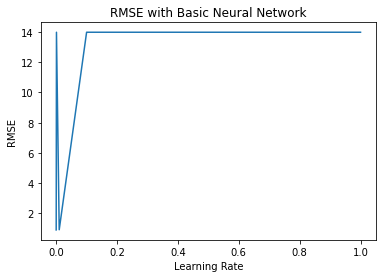

In [10]:
#Plot how RMSE changes with learning rate

plt.plot(learning_rates, rmse_array)
plt.title('RMSE with Basic Neural Network')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.show()

In [11]:
#Find the optimal learning rate (minimizes RMSE)

optimal_idx = np.argmin(rmse_array)
optimal_lr = learning_rates[optimal_idx]

print('Optimal Learning Rate: ', optimal_lr)


#Run the model using the test set data and optimal learning rate to get the RMSE on the test set

model = MovieRecommender(optimal_lr)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', min_delta=0.01, patience=2)
history = model.fit(X_train_array, y_train, epochs=1000, batch_size=32, callbacks=[es],verbose=0)
rmse = model.evaluate(X_test_array, y_test,verbose=0)

print('Test RMSE: ', rmse[1])

Optimal Learning Rate:  1e-05
Test RMSE:  13.957626


In [12]:
#Make the predictions for the test set data

predictions = model.predict(X_test_array, verbose=0)

In [13]:
#Calculate average precision, recall, and F1 scores

X_test_df = pd.DataFrame(X_test)

X_predicted = pd.DataFrame(X_test)

X_predicted[2] = predictions

userID_list = X_test_df[0].unique()

recommendations_indices = np.zeros(shape = (len(userID_list),25))

for idx,i in enumerate(userID_list):
    pred_df = X_predicted[X_predicted[0]==i]
    top = pred_df.nlargest(25, 2)
    recommendations = top[1].values
    recommendations_indices[idx,:] = recommendations

    
precision_matrix = np.zeros(shape=(len(userID_list)))
recall_matrix = np.zeros(shape=(len(userID_list)))
f1_matrix = np.zeros(shape=(len(userID_list)))

for idx,i in enumerate(userID_list):
    ratings_df = X_test_df[X_test_df[0]==i]
    top_movies_rated = ratings_df[ratings_df[2]>=3.5]
    top_rated_indices = top_movies_rated[1].values
    
    tp = len(np.intersect1d(recommendations_indices[idx,:], top_rated_indices))
    fp = len(recommendations_indices)-tp
    fn = len(top_rated_indices)-tp

    precision = tp / (tp + fp + 1e-10)
    precision_matrix[idx] = precision
    recall = tp / (tp + fn + 1e-10)
    recall_matrix[idx] = recall
    f1 = 2.0 * (precision * recall) / (precision + recall + 1e-10)  
    f1_matrix[idx] = f1


avg_precision = np.average(precision_matrix)
avg_recall = np.average(recall_matrix)
avg_f1 = np.average(f1_matrix)
print('Average Precision: ', avg_precision)
print('Average Recall: ', avg_recall)
print('Average F1 Score: ', avg_f1)

Average Precision:  0.01137673676561305
Average Recall:  0.4601128758673247
Average F1 Score:  0.02215893736686533
